# Dispersive Readout for Transmon (2): Data Processing with Classical Electronics
In this Notebook, we aim to **construct the virtual electronics to show how readout signal is processed in real superconducting qubits lab**. The main procedure followes the well-known review article: [A Engineer's Guide for superconducting qubits](https://aip.scitation.org/doi/10.1063/1.5089550).

Part of the coding for low-pass filter is revised from stackoverflow ([Create lowpass band filter in SciPy](https://stackoverflow.com/questions/25191620/creating-lowpass-filter-in-scipy-understanding-methods-and-units))

In [1]:
import numpy as np
from numpy import sin, cos, pi
import scipy as sc
from scipy.special import erf
import scipy.constants as cn

from scipy.signal import butter, lfilter, filtfilt, sosfilt, iirdesign, freqz, freqs
from scipy.fft import fft, rfft, fftfreq
from scipy.io import savemat

import matplotlib.pyplot as plt
#from qutip import *

%matplotlib inline

## Probe Signal and Down-conversion

#### Some Important Physical Quantities for ADC
* Sampling time: T
* Sampling interval: $t_n$=0.625 ns
* Sampling frequency (Sampling Rate): $f_{s,ADC}=1/t_{n}=1.6$ GHz
* \# of sample points: $n=T/0.625=T\cdot f_s$
* Frequency upper bound of the spectrum: $f_{max}=2f_{s}$

Note the dimension convention of scipy functions. (No $2\pi$ for input)

Recall the normality of trigonopmetric functions:
$$
\int_{-\infty}^{\infty}\sin(nx)\sin(mx)=\delta_{n,m} 
$$
$$
\int_{-\infty}^{\infty}\cos(nx)\cos(mx)=\delta_{n,m} 
$$
$$
\int_{-\infty}^{\infty}\sin(nx)\cos(mx)=0
$$

In [2]:
fs_RF = 1.6e4   # GHz, Analog frequency
fs_ADC = 1.6*4  # GHz, ADC sampling frequency
fs = 40         # GHz, Filter sampling frequency

#### Analog Signal (Response from feedline out-port)

With _fs_RF=1.6e4 GHz_, we can make the great approximationthe that signal is continuous (analog signal). The carrier frequency of the signal is denoted _wd_, which is the frequency of drive pulse for readout resonator . 

In [3]:
# Create the original analog signal
wd = 6.5          # GHz
T = 20.0         # ns
n = int(T*fs_RF) # total number of samples
tn = 1/fs_RF
t = np.linspace(0, T, n, endpoint=False)
RF = 20*np.cos(2*np.pi*wd*t)

#### Aliasing (Direct RF sampling using ADC)

[Wiki: Aliasing](https://en.wikipedia.org/wiki/Aliasing)
The plot below showed that me cannot sample the RF signal with carrier frequency _wd_ by directly using ADC. We have to down-convert the signal to a proper frequency range. 

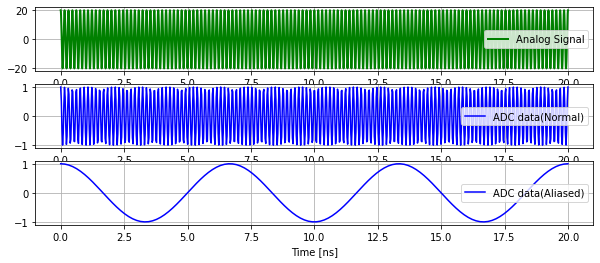

In [4]:
## Good sampling data
t_ = np.linspace(0, T, int(T*fs))
y_ = np.cos(2*np.pi*wd*t_)

## Aliasing
tt_ = np.linspace(0, T, int(T*fs_ADC))
yy_ = np.cos(2*np.pi*wd*tt_)

plt.figure(figsize=[10,4])
plt.subplot(3, 1, 1)
plt.plot(t, RF, 'g-', linewidth=2, label='Analog Signal')
plt.grid()
plt.legend()
plt.subplot(3, 1, 2)
plt.plot(t_, y_, 'b-', label='ADC data(Normal)')
plt.grid()
plt.legend()
plt.subplot(3, 1, 3)
plt.plot(tt_, yy_, 'b-', label='ADC data(Aliased)')
plt.grid()
plt.xlabel('Time [ns]')
plt.legend()
#plt.subplots_adjust(hspace=0.35)
plt.show()

#### Down-conversion
The down-converted signal in this step is called IF signal (~700 MHz, a proper frequency that could be sampled by ADC). 
$$
\omega_{IF}=\omega_{LO}\pm\omega_{RF}
$$

From [Quantum Computing: Prospects and Progress](https://nap.nationalacademies.org/read/25196/chapter/13), we know that we are free enough to choose the range of $\omega_{LO}$ to be 0~12 GHz. 

Analog signal is smooth in definition, while it is somehow 'digitized' because of the hardware limit in real world. Here we choose the sampling frequency of analog signal to be _fs_RF=1.6 e^4_ GHz, a large enough number to avoid aliasing. 


Demonstrate the use of the filter. First, we create some data, which would be filtered for the rest of some steps.

In [5]:
def down_convert(y, t, w_LO, phi0=0):
    '''Down-convert the RF signal'''
    LO = np.cos(2*np.pi * w_LO*t + phi0)
    return LO*y

w_LO = 7         # GHz

# Down-convert signal. We want to recover the <3 Hz part from this.
IF_I = 1/2*down_convert(RF, t, w_LO)
IF_Q = 1/2*down_convert(RF, t, w_LO, phi0=np.pi/2)

#### Compare the Analog Signal and Down-converted Analog Signal
Time-domain signal is easy to display, while the frequency domain is tricky for the frequency range. Due to the large _fs_RF_, the fft result will include so many useless components up to $10^{3}$ GHz and we only need ~10 GHz. The practical hardwares are not able to dissolve peaks of ~10 GHz on the background frequency spectrum ~ 10^3 GHz. Note that due to super high boundary of frequency spectrum, we have to truncate the spectrum to the dominant range we focus.

Part of the coding is forked from: [Plotting a fast Fourier transform in Python](https://stackoverflow.com/questions/25735153/plotting-a-fast-fourier-transform-in-python).

Text(0, 0.5, '|f|')

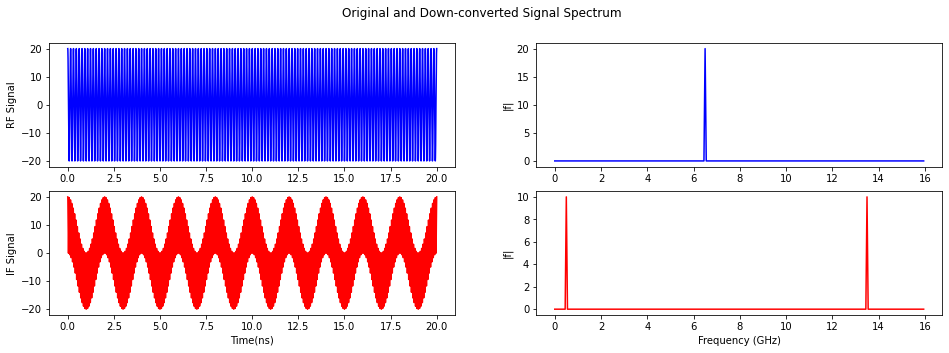

In [8]:
# Fourier transform to check the frequncy spectrum
yf1 = fft(RF) # fft computing and normalization
#yf1 = yf1[range(int(n/2))]
yf2 = fft(IF_I) # fft computing and normalization
#yf2 = yf2[range(int(n/2))]

M = fs_RF//fs_ADC
x_rf = np.linspace(0, fs_RF/2, n//2)

#f = fftfreq(n, 1.0/fs)
#mask = (f > 0) * (f < 10)

fig, axs = plt.subplots(2, 2, figsize=[16, 5])
fig.suptitle('Original and Down-converted Signal Spectrum')
axs[0,0].plot(t, RF, 'b')
axs[0,0].set_ylabel('RF Signal')
axs[1,0].plot(t, IF_I, 'r')
axs[1,0].set_xlabel('Time(ns)')
axs[1,0].set_ylabel('IF Signal')

## Truncate the spectrum
axs[0,1].plot(x_rf[:n//1000], 2/n * np.abs(yf1[:n//1000]), 'b')
axs[0,1].set_ylabel('|f|')
axs[1,1].plot(x_rf[:n//1000], 2/n * np.abs(yf2[:n//1000]), 'r')
axs[1,1].set_xlabel('Frequency (GHz)')
axs[1,1].set_ylabel('|f|')

#### Construct a low-pass filter
Computing the a (numerator) and b (denominator) [(Signal Processing Basics)](http://www.ece.northwestern.edu/local-apps/matlabhelp/toolbox/signal/basics27.html) is the core of building a digital filter in coding. The numerator and denominator of a filter is calculated using _'butter'_ in SciPy. Also, by applying _freqz_, we compute the frequency response of a digital filter. Finally, we use _lfilter_ as.

**Analog vs Ditigal Filter**

**Ditigal Low-pass Filter**

In [9]:
def butter_lowpass(cutoff, fs, order=10):
    '''Calculate the numerator and denominator of low-pass filter'''
    return butter(order, cutoff, btype='low', output='sos', fs=fs)

# Filter requirements.
order = 3
cutoff = 3 # GHz
# Get the filter coefficients so we can check its frequency response.
sos = butter_lowpass(cutoff, fs_RF, order)

# Plot the frequency response.
#w, h = sc.signal.sosfreqz(sos, worN=n) #Compute the frequency response of a digital filter
#plt.subplot(2, 1, 1)
#plt.plot(w, np.abs(h), 'b')
#plt.plot(cutoff, 0.5*np.sqrt(2), 'ko')
#plt.axvline(cutoff, color='k')
#plt.xlim(0, fs/2)
#plt.title("Low-pass Filter Frequency Response")
#plt.xlabel('Frequency [GHz]')
#plt.grid()

#### Compare the unfiltered/filtered IF signal

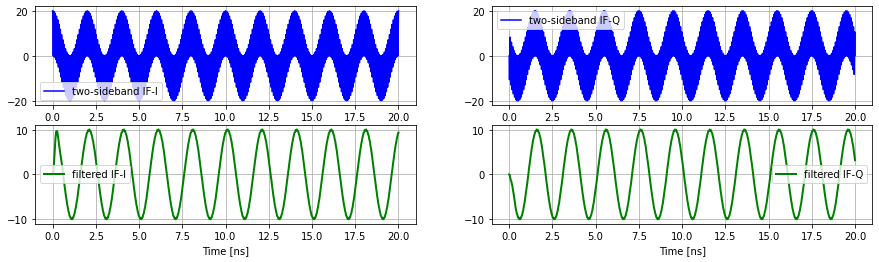

In [12]:
def butter_lowpass_filter(data, cutoff, fs, order=4):
    '''Apply the filter to signal data'''
    b, a = digital_lowpass(cutoff, fs, order=order)
    y = filtfilt(b, a, data)
    return y

# Filter the data, and plot both the original and filtered signals.
#filtered_IF = butter_lowpass_filter(IF, cutoff, fs, order)

filtered_IF_I = sosfilt(sos, IF_I)
filtered_IF_Q = sosfilt(sos, IF_Q)

plt.figure(figsize=(15,4))
plt.subplot(2, 2, 1)
plt.plot(t, IF_I, 'b-', label='two-sideband IF-I')
plt.grid()
plt.legend()
plt.subplot(2, 2, 3)
plt.plot(t, filtered_IF_I, 'g-', linewidth=2, label='filtered IF-I')
plt.xlabel('Time [ns]')
plt.grid()
plt.legend()
plt.subplot(2, 2, 2)
plt.plot(t, IF_Q, 'b-', label='two-sideband IF-Q')
plt.grid()
plt.legend()
plt.subplot(2, 2, 4)
plt.plot(t, filtered_IF_Q, 'g-', linewidth=2, label='filtered IF-Q')
plt.xlabel('Time [ns]')
plt.grid()
plt.legend()

#plt.subplots_adjust(hspace=0.35)
plt.show()

Text(0, 0.5, '|f|')

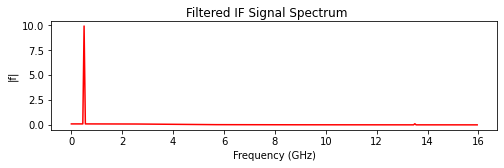

In [11]:
yf3 = fft(filtered_IF_I)

fig, axs = plt.subplots(figsize=(8,2))
fig.suptitle('Filtered IF Signal Spectrum')
axs.plot(x_rf[:n//1000], 2/n * np.abs(yf3[:n//1000]), 'r')
axs.set_xlabel('Frequency (GHz)')
axs.set_ylabel('|f|')

#### ADC (Digitation of Analog IF Signal)

The digitized signal has much lower $f_{s}$ so we could easily what the frequncy spectrum looks like. Now it is time for us to digitize the analog signal. We also call this step 'digitization' or 'sampling with ADC'. Numerically, we quantize the signal with fs=1.6e^3 GHz using an ADC with fs=1.6 GHz. 

According to Nyquist theorem, the limit of hardware gives rise to boundary condition, $f_{s}>2f_{IF}$, which is why we have to downconvert the RF signal to IF signal ~700 MHz. 

Text(0.5, 0, 't (ns)')

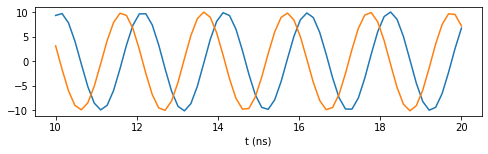

In [16]:
M = int(fs_RF/fs_ADC)
t_start = 0  # ns
t_delay = 10  # ns
t_end = 20    # ns

## Sampling time width
if M % 2 == 0:
    tt = np.linspace(t_delay, t_end, int((t_end-t_delay-t_start) * fs_ADC))
elif M % 2 == 1:
    tt = np.linspace(t_delay, t_end, int(1+(t_end-t_delay-t_start) * fs_ADC))

## Sampling points
n1 = int(n*(t_start+t_delay)/T)
n2 = int(n*t_end/T)

IF_out_I = filtered_IF_I[n1:n2:M]
IF_out_Q = filtered_IF_Q[n1:n2:M]

plt.figure(figsize=(8,2))
plt.plot(tt, IF_out_I)
plt.plot(tt, IF_out_Q)
plt.xlabel('t (ns)')

#### Gaussian Noise

Text(0.5, 0, 't (ns)')

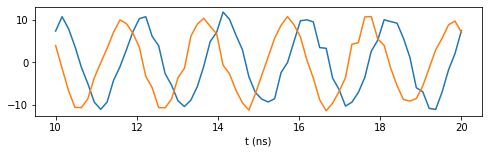

In [14]:
from numpy.matlib import repmat 

## Repeat the measurement
repeat = 1000
IF_I_mat = repmat(IF_out_I, 1000, 1)
IF_Q_mat = repmat(IF_out_Q, 1000, 1)

## Add Gaussian noise
noisy_IF_I = IF_out_I + np.random.randn(repeat, len(IF_out_I))
noisy_IF_Q = IF_out_Q + np.random.randn(repeat, len(IF_out_Q))

plt.figure(figsize=(8,2))
plt.plot(tt, noisy_IF_I[3,:])
plt.plot(tt, noisy_IF_Q[3,:])
plt.xlabel('t (ns)')

#### Discriminator
Before the cluster step, we take the average over the complex plane.

Taking average to generate the IQ points:

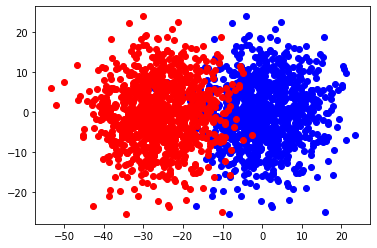

In [70]:
Av_IF_I_0 = noisy_IF_I.sum(axis=1)
Av_IF_Q_0 = noisy_IF_Q.sum(axis=1)

random_phase = 1.4*np.pi

Av_IF_I_1 = Av_IF_I_0 - 26
Av_IF_Q_1 = Av_IF_Q_0

plt.figure()
plt.scatter(Av_IF_I_0, Av_IF_Q_0, marker='o', color='blue')
plt.scatter(Av_IF_I_1, Av_IF_Q_1, marker='o', color='red')

In [71]:
from scipy.cluster.vq import kmeans2

In [72]:
X0 = np.array([Av_IF_I_0, Av_IF_Q_0]).T
X1 = np.array([Av_IF_I_1, Av_IF_Q_1]).T

X = np.concatenate((X0, X1))

In [73]:
centroids, labels = kmeans2(X, 2)

In [74]:
counts = np.bincount(labels)
counts

array([ 996, 1004], dtype=int64)

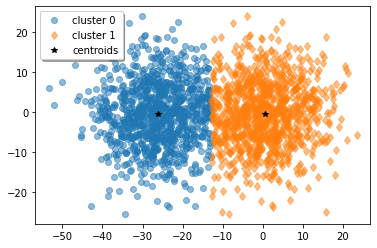

In [75]:
w0 = X[labels == 0]
w1 = X[labels == 1]
plt.plot(w0[:, 0], w0[:, 1], 'o', alpha=0.5, label='cluster 0')
plt.plot(w1[:, 0], w1[:, 1], 'd', alpha=0.5, label='cluster 1')
plt.plot(centroids[:, 0], centroids[:, 1], 'k*', label='centroids')
plt.axis('equal')
plt.legend(shadow=True)
plt.show()

See: [dB conversion](https://dspillustrations.com/pages/posts/misc/decibel-conversion-factor-10-or-factor-20.html)

In [ ]:
def dB_conversion(signal, dB):
    '''Amplitude conversion by dB'''
    return signal*10**(dB/20)

A simulation methodology for superconducting qubit readout fidelity

## Band-pass filter

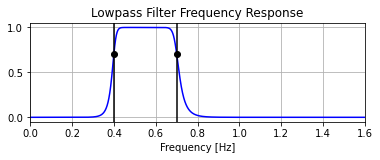

In [131]:
def butter_bandpass(lowcut, highcut, fs, order=5):
    return butter(order, [lowcut, highcut], fs=fs, btype='band', analog=False)

def butter_bandpass_filter(data, fs, lowcut, highcut, order=5):
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    y = lfilter(b, a, data)
    return y

lowcut = 0.4
highcut = 0.7

# Get the filter coefficients so we can check its frequency response.
b, a = butter_bandpass(lowcut, highcut, fs, order)

# Plot the frequency response.
w, h = freqz(b, a, fs=fs, worN=8000)
plt.subplot(2, 1, 1)
plt.plot(w, np.abs(h), 'b')
plt.plot(lowcut, 0.5*np.sqrt(2), 'ko')
plt.plot(highcut, 0.5*np.sqrt(2), 'ko')
plt.axvline(lowcut, color='k')
plt.axvline(highcut, color='k')
plt.xlim(0, 0.5*fs)
plt.title("Bandpass Filter Frequency Response")
plt.xlabel('Frequency [Hz]')
plt.grid()


# Demonstrate the use of the filter.
# First make some data to be filtered.
t_M = 20     # ns
n = int(T * fs) # total number of samples
t = np.linspace(0, T, n, endpoint=False)

# "Noisy" data.  We want to recover the 1.2 Hz signal from this.
t_lst = np.linspace(0, t_M, int(t_M/0.625))
data = f(t_lst, 0.6)

# Filter the data, and plot both the original and filtered signals.
y = butter_bandpass_filter(data, fs, lowcut, highcut, order)

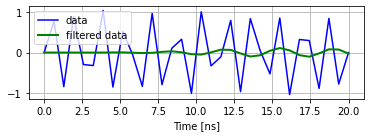

In [132]:
plt.subplot(2, 1, 2)
plt.plot(t_lst, data, 'b-', label='data')
plt.plot(t_lst, y, 'g-', linewidth=2, label='filtered data')
plt.xlabel('Time [ns]')
plt.grid()
plt.legend()

plt.subplots_adjust(hspace=0.35)
plt.show()